# Projet Auto ML - Part 4

## Auteurs : 
<font size="3"> ***BENDAOUD Islam***</font> 

<font size="3"> ***ISSAAD Sarah***</font> 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Pre-processing

In [2]:
df = pd.read_csv('Fifa 23 Players Data.csv')  
df["BMI"] = df['Weight(in kg)']/((df['Height(in cm)']/100)**2)
data = df.drop(['Known As' , 'National Team Image Link' , 'Image Link'] ,axis = 1 )
data = data.drop(['National Team Name','National Team Position' , 'Club Name' ], axis=1)
data['Positions Played'] = data['Positions Played'].str.split(',').str[0]
data['Height(in m)'] = data['Height(in cm)'] / 100

#drop cm since it's 100% linear correlated to the heigh(m)
data.drop('Height(in cm)' , axis=1, inplace=True)
# Calculate BMI
data['BMI'] = data['Weight(in kg)'] / (data['Height(in m)'] ** 2)
data.drop('Weight(in kg)' , axis=1, inplace=True)

def simple_pos(pos):
    if pos in ["RB" , "LB" , "RWB" , "LWB" , "CB"] : 
        return 'DEF'
    elif pos in ["CDM"  , "CAM" ,"RM"  , "LM"  , "CM"] : 
        return "MID"
    elif pos in ["CF" , "ST" , "LW" , "RW" , "LF" , "RF"] : 
        return "ATK"
    elif pos == "GK": 
        return "GK"
    else :
        return "-"
    
columns_to_change = ["Best Position" , "Positions Played", "Club Position"]
data[columns_to_change] = data[columns_to_change].applymap(simple_pos)
data = data.drop(["Positions Played" , "Club Position"] , axis = 1 )
data = data.drop(["National Team Jersey Number" , "Club Jersey Number" , 'Contract Until' , 'On Loan'] , axis = 1 )

def change_rates(rate ): 
    if rate == "Medium" : 
        return 2
    elif rate == "Low" : 
        return 1
    elif rate == "High" : 
        return 3

columns_to_change = ["Attacking Work Rate" , "Defensive Work Rate"]
data[columns_to_change] = data[columns_to_change].applymap(change_rates)


def change_ages(age) : 
    if age < 20 : 
        return 0 
    elif age >= 20 and age < 25 : 
        return 1 
    if age >= 25 and age < 30 :
        return 2
    elif age >=30 and age <35 : 
        return 3
    else : 
        return 4
    
columns_to_change = ["Age"]
data[columns_to_change] = data[columns_to_change].applymap(change_ages)

df_encoded = pd.get_dummies(data, columns=['Best Position', 'Preferred Foot'])

# standardize the columns Value(in Euro) and Wage(in Euro) 
scaler = StandardScaler()
df_encoded['Value(in Euro)'] = scaler.fit_transform(df_encoded[['Value(in Euro)']])
df_encoded['Wage(in Euro)'] = scaler.fit_transform(df_encoded[['Wage(in Euro)']])



df_encoded["DValue"], bin_edges_value = pd.cut(df_encoded['Value(in Euro)'], bins = 20, labels=False, right=False, retbins=True)
df_encoded["DWage"], bin_edges_wage = pd.cut(df_encoded['Wage(in Euro)'], bins=20, labels=False, right=False, retbins=True)
# drop where count of values is less than 3
df_encoded = df_encoded.groupby('DValue').filter(lambda x: len(x) > 2)
df_encoded = df_encoded.groupby('DWage').filter(lambda x: len(x) > 2)

yw = df_encoded["DWage"]
yv = df_encoded["DValue"]


print(yv.value_counts() , yw.value_counts())

X = df_encoded.drop(columns=['Nationality', "DWage" , "DValue", 'Overall', 'Full Name', 'Wage(in Euro)', 'Value(in Euro)'])



Xw_train, Xw_test, yw_train, yw_test = train_test_split(X, yw, test_size=0.1,stratify = yw ,  random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X, yv, test_size=0.1,stratify = yv , random_state=42)

0     17436
1       565
2       238
3       132
4        49
5        40
6        23
7        14
8        11
9         9
10        8
11        5
12        2
Name: DValue, dtype: int64 0     16739
1      1121
2       327
3       173
4        60
5        35
6        23
8        23
7        12
10        8
9         7
11        4
Name: DWage, dtype: int64


In [3]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


# First Heuristic :  RandomSearch (with RandomizedSearchCV)

In [ ]:
print('Optimizing Linear Regression . . .')

# Decision Tree
dt_param_dist = {'max_depth': randint(1, 20),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

dt_random_search_w = RandomizedSearchCV(LinearRegression(), dt_param_dist, n_iter=10, cv=2, n_jobs=-1)
dt_random_search_w.fit(Xw_train, yw_train)

In [56]:
print('Optimizing Decision Tree . . .')

# Decision Tree
dt_param_dist = {'max_depth': randint(1, 20),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

dt_random_search_w = RandomizedSearchCV(DecisionTreeClassifier(), dt_param_dist, n_iter=10, cv=2, n_jobs=-1)
dt_random_search_w.fit(Xw_train, yw_train)

Optimizing Decision Tree . . .


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f998046e820>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f99d3b10f70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f998043f730>})

In [57]:
dt_random_search_v = RandomizedSearchCV(DecisionTreeClassifier(), dt_param_dist, n_iter=10, cv=2, n_jobs=-1)
dt_random_search_v.fit(Xv_train, yv_train)

RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f998046e820>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f99d3b10f70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f998043f730>})

In [58]:
print('Optimizing LDA . . .')

# Linear Discriminant Analysis (LDA)
lda_param_dist = {'n_components': randint(1, min(Xw_train.shape[1], len(np.unique(yw_train))) - 1)}

lda_random_search_w = RandomizedSearchCV(LinearDiscriminantAnalysis(), lda_param_dist, n_iter=10, cv=2, n_jobs=-1)
lda_random_search_w.fit(Xw_train, yw_train)


Optimizing LDA . . .


RandomizedSearchCV(cv=2, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
                   param_distributions={'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f99a383f4f0>})

In [59]:
lda_random_search_v = RandomizedSearchCV(LinearDiscriminantAnalysis(), lda_param_dist, n_iter=10, cv=2, n_jobs=-1)
lda_random_search_v.fit(Xv_train, yv_train)

RandomizedSearchCV(cv=2, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
                   param_distributions={'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f99a383f4f0>})

In [60]:
from sklearn.metrics import accuracy_score

# Assuming X_train_v, X_test, X_train_w, y_train_v, y_test, y_train_w are your data and labels

# Function to get the best model and its performance
def get_best_model_and_score(random_search, X_train, y_train, X_test, y_test):
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # Training performance
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test performance
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return best_model, best_params, train_accuracy, test_accuracy

# Get best models and scores
lda_model_v, lda_params_v, lda_train_score_v, lda_test_score_v = get_best_model_and_score(lda_random_search_v, Xv_train, yv_train, Xv_test, yv_test)
dt_model_v, dt_params_v, dt_train_score_v, dt_test_score_v = get_best_model_and_score(dt_random_search_v, Xv_train, yv_train, Xv_test, yv_test)
dt_model_w, dt_params_w, dt_train_score_w, dt_test_score_w = get_best_model_and_score(dt_random_search_w, Xw_train, yw_train, Xw_test, yw_test)
lda_model_w, lda_params_w, lda_train_score_w, lda_test_score_w = get_best_model_and_score(lda_random_search_w, Xw_train, yw_train, Xw_test, yw_test)

results_df = pd.DataFrame({
    'Model': ['LDA value', 'Decision Tree value' ,  'Decision Tree wage', 'LDA wage' ],
    'Training Accuracy': [lda_train_score_v,dt_train_score_v, dt_train_score_w, lda_train_score_w ],
    'Test Accuracy': [lda_test_score_v, dt_test_score_v, dt_test_score_w, lda_test_score_w]
})



In [61]:
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)
results_df

,Model,Training Accuracy,Test Accuracy
1,Decision Tree value,0.987948,0.978425
0,LDA value,0.979554,0.975189
3,LDA wage,0.910961,0.912621
2,Decision Tree wage,0.934944,0.910464


# Second Heuristic : Genetic Algorithm (with TPOT)

In [71]:
from tpot import TPOTClassifier

In [72]:
from sklearn.preprocessing import StandardScaler

tpot_config = {
    'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': {
        'n_components': list(range(1, min(X.shape[0], X.shape[1]))),
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
        'store_covariance': [True, False]
    },
    
    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None] + list(range(1, 30)),
        'min_samples_split': list(range(2, 30)),
        'min_samples_leaf': list(range(1, 30)),
        'splitter': ['best', 'random'],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },

    'sklearn.preprocessing.StandardScaler': {},  # Standardization step
}



In [73]:
tpot = TPOTClassifier(generations=30, population_size=100, verbosity=2, config_dict=tpot_config)


In [74]:
tpot.fit(Xv_train, yv_train)



Optimization Progress:   0%|          | 0/3100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9833913798496434

Generation 2 - Current best internal CV score: 0.9835712898946211

Generation 3 - Current best internal CV score: 0.983871086039714

Generation 4 - Current best internal CV score: 0.983871086039714

Generation 5 - Current best internal CV score: 0.983871086039714

Generation 6 - Current best internal CV score: 0.9839310380780834

Generation 7 - Current best internal CV score: 0.9841109301464377

Generation 8 - Current best internal CV score: 0.9841109481230609

Generation 9 - Current best internal CV score: 0.9841709001614302

Generation 10 - Current best internal CV score: 0.9841709001614302

Generation 11 - Current best internal CV score: 0.9843510079492628

Generation 12 - Current best internal CV score: 0.9844708940493782

Generation 13 - Current best internal CV score: 0.9844708940493782

Generation 14 - Current best internal CV score: 0.9844708940493782

Generation 15 - Current best internal CV score: 0.984650804

TPOTClassifier(config_dict={'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': {'n_components': [1,
                                                                                                          2,
                                                                                                          3,
                                                                                                          4,
                                                                                                          5,
                                                                                                          6,
                                                                                                          7,
                                                                                                          8,
                                                                                                          9,
                                                                                                          10,
                                                                                                          11,
                                                                                                          12,
                                                                                                          13,
                                                                                                          14,
                                                                                                          15,
                                                                                                          16,
                                                                                                          17,
                                                                                                          18,
                                                                                                          19,
                                                                                                          20,
                                                                                                          21,
                                                                                                          22,
                                                                                                          23,
                                                                                                          24,
                                                                                                          25,
                                                                                                          26,
                                                                                                          27,
                                                                                                          28,
                                                                                                          29,
                                                                                                          30, ...],
                                                                                         'shrinkage': [None,
                                                                                                       'auto',
                                                                                                       0.1,
                                                                                                       0.5,
                                                                                                       0.9],
                                                                                         'solver': ['svd',
                                                   

In [75]:
print(tpot.score(Xv_test, yv_test))

0.982200647249191


/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [76]:
tpot.export('tpot_digits_pipeline.py')

In [77]:

tpotw = TPOTClassifier(generations=30, population_size=100, verbosity=2, config_dict=tpot_config)


In [78]:
tpotw.fit(Xw_train, yw_train)


Optimization Progress:   0%|          | 0/3100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9123998612204689

Generation 2 - Current best internal CV score: 0.9123998612204689

Generation 3 - Current best internal CV score: 0.912579465662852

Generation 4 - Current best internal CV score: 0.912579465662852

Generation 5 - Current best internal CV score: 0.9128790640650898

Generation 6 - Current best internal CV score: 0.9131193396107701

Generation 7 - Current best internal CV score: 0.9140184583967009

Generation 8 - Current best internal CV score: 0.9145578110225461

Generation 9 - Current best internal CV score: 0.9153972114662092

Generation 10 - Current best internal CV score: 0.9153972114662092

Generation 11 - Current best internal CV score: 0.9153972114662092

Generation 12 - Current best internal CV score: 0.9153972114662092

Generation 13 - Current best internal CV score: 0.9153972114662092

Generation 14 - Current best internal CV score: 0.9153972114662092

Generation 15 - Current best internal CV score: 0.91539721

TPOTClassifier(config_dict={'sklearn.discriminant_analysis.LinearDiscriminantAnalysis': {'n_components': [1,
                                                                                                          2,
                                                                                                          3,
                                                                                                          4,
                                                                                                          5,
                                                                                                          6,
                                                                                                          7,
                                                                                                          8,
                                                                                                          9,
                                                                                                          10,
                                                                                                          11,
                                                                                                          12,
                                                                                                          13,
                                                                                                          14,
                                                                                                          15,
                                                                                                          16,
                                                                                                          17,
                                                                                                          18,
                                                                                                          19,
                                                                                                          20,
                                                                                                          21,
                                                                                                          22,
                                                                                                          23,
                                                                                                          24,
                                                                                                          25,
                                                                                                          26,
                                                                                                          27,
                                                                                                          28,
                                                                                                          29,
                                                                                                          30, ...],
                                                                                         'shrinkage': [None,
                                                                                                       'auto',
                                                                                                       0.1,
                                                                                                       0.5,
                                                                                                       0.9],
                                                                                         'solver': ['svd',
                                                   

In [70]:
print(tpot.score(Xw_test, yw_test))

0.912621359223301


# Third heuristic: Hyperopt-sklearn (with env)

In [3]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /private/var/folders/35/9x_5dznn4pz7j06jf9frns8w0000gn/T/pip-req-build-_x5trq66
  Running command git clone --filter=blob:none --quiet https://github.com/hyperopt/hyperopt-sklearn /private/var/folders/35/9x_5dznn4pz7j06jf9frns8w0000gn/T/pip-req-build-_x5trq66
  Resolved https://github.com/hyperopt/hyperopt-sklearn to commit 4bc286479677a0bfd2178dac4546ea268b3f3b77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of hpsklearn to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version: 1.25.0 Requires-Python >=3.9; 1.25.0rc1 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.0b1 Requires-Python <3.13,>=3.9; 1.26.0rc1 Requires

In [4]:
from hpsklearn import HyperoptEstimator, decision_tree_classifier, linear_discriminant_analysis, gaussian_nb, svc, logistic_regression
from hyperopt import hp


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


ImportError: cannot import name 'decision_tree_classifier' from 'hpsklearn' (/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/hpsklearn/__init__.py)

**Note: Does not work on LDA.**

In [6]:
# We made four runs with these seeds:
seeds = [42, 36541, 4511451]

### HPO on the various algorithms

### Decision Tree Classifier

In [12]:
dt_scores = []
dt_train_scores = []
for seed in seeds:
    estim_dt = HyperoptEstimator( classifier=decision_tree_classifier('my_decision_tree_classifier'), seed=seed)
    estim_dt.fit(Xv_train, yv_train)
    dt_score = estim_dt.score(Xv_test, yv_test)
    dt_scores.append(dt_score)
    print(f"Logistic_regression score : {dt_score}")
    print(f"Best model : {estim_dt.best_model()}")
    dt_train_score = estim_dt.score(Xv_train, yv_train)
    dt_train_scores.append(dt_train_score)
print(f"dt_scores : {dt_scores}")
print(f"dt_train_scores : {dt_train_scores}")

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:04<00:00,  4.57s/trial, best loss: 0.017985611510791366]
Logistic_regression score : 0.9762675296655879
Best model : {'learner': DecisionTreeClassifier(criterion='entropy', random_state=2, splitter='random'), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


100%|██████████| 10/10 [00:08<00:00,  8.28s/trial, best loss: 0.027877697841726667]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Logistic_regression score : 0.9741100323624595
Best model : {'learner': DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0), 'preprocs': (StandardScaler(),), 'ex_preprocs': ()}
100%|██████████| 10/10 [00:09<00:00,  9.61s/trial, best loss: 0.016786570743405282]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Logistic_regression score : 0.9795037756202805
Best model : {'learner': DecisionTreeClassifier(max_features=0.6016283442771942, max_leaf_nodes=15,
                       random_state=4, splitter='random'), 'preprocs': (PCA(n_components=76, whiten=True),), 'ex_preprocs': ()}
dt_scores : [0.9762675296655879, 0.9741100323624595, 0.9795037756202805]
dt_train_scores : [1.0, 0.9740376543950114, 0.9829116200983331]


In [13]:
dt_scores

[0.9762675296655879, 0.9741100323624595, 0.9795037756202805]

### Logistic Regression

In [6]:
lr_scores = []
lr_train_scores = []
for seed in seeds:
    estim_lr = HyperoptEstimator( classifier=logistic_regression('my_logistic_regression'), seed=seed)
    estim_lr.fit(Xv_train, yv_train)
    lr_score = estim_lr.score(Xv_test, yv_test)
    lr_scores.append(lr_score)
    print(f"Logistic_regression score : {lr_score}")
    print(f"Best model : {estim_lr.best_model()}")
    lr_train_score = estim_lr.score(Xv_train, yv_train)
    lr_train_scores.append(lr_train_score)
print(f"Logistic_regression score : {lr_scores}")
print(f"Logistic_regression train score : {lr_train_scores}")

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:11<00:00, 11.24s/trial, best loss: 0.02877697841726623]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Logistic_regression score : 0.9757281553398058
Best model : {'learner': LogisticRegression(C=0.8441780584655098, max_iter=558, n_jobs=1, random_state=1,
                   solver='sag', tol=0.00024159208827165694), 'preprocs': (StandardScaler(),), 'ex_preprocs': ()}
100%|██████████| 10/10 [00:54<00:00, 54.44s/trial, best loss: 0.039868105515587504]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Logistic_regression score : 0.9590075512405609
Best model : {'learner': LogisticRegression(C=1.1308093890779032, max_iter=756, n_jobs=1, penalty='l1',
                   random_state=2, solver='liblinear',
                   tol=2.9100307874096604e-05), 'preprocs': (MinMaxScaler(clip=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}
100%|██████████| 10/10 [00:16<00:00, 16.17s/trial, best loss: 0.01918465227817745]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Logistic_regression score : 0.9784250269687162
Best model : {'learner': LogisticRegression(C=1.0424179853175266, max_iter=708, n_jobs=1, random_state=0,
                   solver='newton-cg', tol=0.0008337271595944857), 'preprocs': (PCA(n_components=4, whiten=True),), 'ex_preprocs': ()}
Logistic_regression score : [0.9757281553398058, 0.9590075512405609, 0.9784250269687162]
Logistic_regression train score : [0.9818923132270057, 0.9584482551864733, 0.9817723947715553]


In [7]:
print(f"Logistic_regression score : {lr_scores}")
print(f"Logistic_regression train score : {lr_train_scores}")

Logistic_regression score : [0.9757281553398058, 0.9590075512405609, 0.9784250269687162]
Logistic_regression train score : [0.9818923132270057, 0.9584482551864733, 0.9817723947715553]


### Gaussian Naive Bayes

In [ ]:
gnb_scores = []
gnb_train_scores = []
for seed in seeds:
    estim_gnb = HyperoptEstimator( classifier=gaussian_nb('my_gnb'), seed=seed)
    estim_gnb.fit(Xv_train, yv_train)
    gnb_score = estim_gnb.score(Xv_test, yv_test)
    gnb_scores.append(gnb_score)
    print(f"Gaussian Naive Bayes score : {gnb_score}")
    print(f"Best model : {estim_gnb.best_model()}")
    gnb_train_score = estim_gnb.score(Xv_train, yv_train)
    gnb_train_scores.append(gnb_train_score)
print(f"gnb_scores : {gnb_scores}")
print(f"gnb_train_scores : {gnb_train_scores}")

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:07<00:00,  7.54s/trial, best loss: 0.03627098321342925]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Gaussian Naive Bayes score : 0.9606256742179072
Best model : {'learner': GaussianNB(), 'preprocs': (PCA(n_components=28),), 'ex_preprocs': ()}
100%|██████████| 10/10 [00:04<00:00,  4.98s/trial, best loss: 0.03627098321342925]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Gaussian Naive Bayes score : 0.9606256742179072
Best model : {'learner': GaussianNB(), 'preprocs': (PCA(n_components=76),), 'ex_preprocs': ()}
 50%|█████     | 1/2 [00:04<?, ?trial/s, best loss=?]
Gaussian Naive Bayes score : 0.012405609492988134
Best model : {'learner': GaussianNB(), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


 50%|█████     | 1/2 [00:04<?, ?trial/s, best loss=?]


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Gaussian Naive Bayes score : 0.9606256742179072
Best model : {'learner': GaussianNB(), 'preprocs': (StandardScaler(with_std=False),), 'ex_preprocs': ()}
gnb_scores : [0.9606256742179072, 0.9606256742179072, 0.012405609492988134, 0.9606256742179072]
gnb_train_scores : [0.9631850341767598, 0.9631850341767598, 0.012711356277731144, 0.9629451972658593]


### Support Vector Classifier

In [8]:
svc_scores = []
svc_train_scores = []
for seed in seeds:
    estim_svc = HyperoptEstimator( classifier=svc('my_svc'), seed=seed)
    estim_svc.fit(Xv_train, yv_train)
    svc_score = estim_svc.score(Xv_test, yv_test)
    svc_scores.append(svc_score)
    print(f"SVC score : {svc_score}")
    print(f"Best model : {estim_svc.best_model()}")
    svc_train_score = estim_svc.score(Xv_train, yv_train)
    svc_train_scores.append(svc_train_score)
print(f"svc_scores : {svc_scores}")
print(f"svc_train_scores : {svc_train_scores}")

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

### LDA : does not work.

In [ ]:
try: 
    estim_lda = HyperoptEstimator( classifier=linear_discriminant_analysis('my_lda'))
    estim_lda.fit(Xv_train, yv_train)
    print(f"LDA score : {estim_lda.score(Xv_test, yv_test)}")
    print(f"Best model : {estim_lda.best_model()}")
except Exception as e:
    print(str(e))

 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

job exception: The leading minor of order 17 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.



 50%|█████     | 1/2 [00:04<?, ?trial/s, best loss=?]
The leading minor of order 17 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.


In [ ]:
# Boxplot of all test scores :

In [ ]:
[dt_scores, lr_scores, gnb_scores, svc_scores]

[[0.9789644012944984,
  0.9848975188781014,
  0.9757281553398058,
  0.9832793959007551],
 [0.97680690399137,
  0.9741100323624595,
  0.9590075512405609,
  0.9606256742179072],
 [0.9606256742179072,
  0.9606256742179072,
  0.9606256742179072,
  0.9606256742179072],
 [0.9832793959007551,
  0.9789644012944984,
  0.9800431499460626,
  0.9832793959007551]]

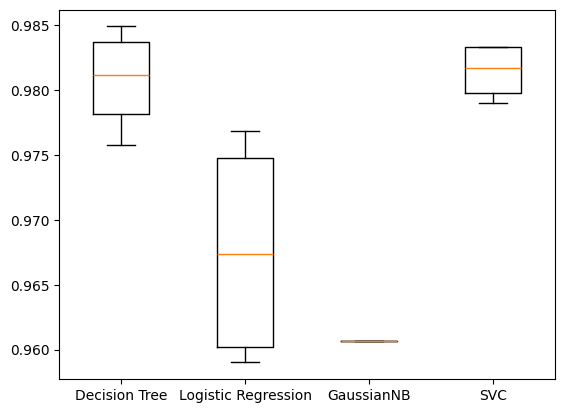

In [ ]:
plt.boxplot([dt_scores, lr_scores, gnb_scores, svc_scores], labels=['Decision Tree', 'Logistic Regression', 'GaussianNB', 'SVC'])
plt.show()

In [ ]:
plt.boxplot([dt_train_scores, lr_train_scores, gnb_train_scores, svc__train_scores], labels=['Decision Tree', 'Logistic Regression', 'GaussianNB', 'SVC'])
plt.show()

### Scores for HPO:

In [ ]:
# With means
results_hpo_df_means = pd.DataFrame({
    'Model': ['Decision Tree value', 'Logistic Regression Value','Gaussian Naive Bayes value', 'SVC value'],
    'Training Accuracy': [np.mean(dt_train_scores), np.mean(lr_train_scores), np.mean(gnb_train_scores), np.mean(svc_train_scores)],
    'Test Accuracy': [np.mean(dt_scores), np.mean(lr_scores), np.mean(gnb_scores), np.mean(svc_scores)]
})
results_hpo_df_means


,Model,Training Accuracy,Test Accuracy
0,Decision Tree value,1.000000,0.980717
1,Logistic Regression Value,0.971744,0.967638
2,Gaussian Naive Bayes value,0.963185,0.960626
3,SVC value,0.987289,0.981392


In [ ]:
# With medians
results_hpo_df_medians = pd.DataFrame({
    'Model': ['Decision Tree value', 'Logistic Regression Value','Gaussian Naive Bayes value', 'SVC value'],
    'Training Accuracy': [np.median(dt_train_scores), np.median(lr_train_scores), np.median(gnb_train_scores), np.median(svc_train_scores)],
    'Test Accuracy': [np.median(dt_scores), np.median(lr_scores), np.median(gnb_scores), np.median(svc_scores)]
})
results_hpo_df_medians

,Model,Training Accuracy,Test Accuracy
0,Decision Tree value,1.000000,0.981122
1,Logistic Regression Value,0.969841,0.967368
2,Gaussian Naive Bayes value,0.963185,0.960626
3,SVC value,0.985280,0.981661


### Multiple classifiers

In [7]:
clf = hp.pchoice( 'my_classifiers', 
          [ (0.25, decision_tree_classifier('my_classifiers.decision_tree_classifier') ), 
            (0.25, gaussian_nb('my_classifiers.gnb') ), 
            (0.25, svc('my_classifiers.svc') ), 
            (0.25, logistic_regression('my_classifiers.lr'))])

In [8]:
classifiers_scores = []
for seed in seeds:
    estim2 = HyperoptEstimator( classifier=clf, seed=seed)
    estim2.fit(Xv_train, yv_train)
    print(f"Best model : {estim2.best_model()}")
    classifiers_score = estim2.score(Xv_test, yv_test)
    print(f"Test accuracy : {classifiers_score}")
    classifiers_scores.append(classifiers_score)
print(f"classifiers_scores : {classifiers_scores}")

100%|██████████| 10/10 [00:15<00:00, 15.71s/trial, best loss: 0.016786570743405282]
Best model : {'learner': SVC(C=1.1949957655455028, coef0=0.763452406794348, degree=2, random_state=3,
    shrinking=False, tol=0.0023561475053219647), 'preprocs': (PCA(n_components=76),), 'ex_preprocs': ()}


c:\Users\x-app\Anaconda3\envs\tp_mlops\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Test accuracy : 0.9832793959007551
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

{'learner': DecisionTreeClassifier(max_features=0.29416369047394064, max_leaf_nodes=15,
                       random_state=3), 'preprocs': (MinMaxScaler(clip=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}

In [ ]:
print(f"Mean of scores : {np.mean(classifiers_scores)}, median of scores : {np.median(classifiers_scores)}")

### Base scores :

In [ ]:
previous_scores_df = pd.DataFrame({
    'Algorithm': ['DecisionTree', 'Logistic Regression','Gaussian Naive Bayes', 'SVC', 'LDA'],
    'Accuracy Dwage': [0.925, 0.933, 0.937, 0.937, 0.931],
    'Accuracy Dvalue': [0.981, 0.960, 0.970, 0.970, 0.980]
})

In [ ]:
previous_scores_df

,Algorithm,Accuracy Dwage,Accuracy Dvalue
0,DecisionTree,0.925,0.981
1,Logistic Regression,0.933,0.960
2,Gaussian Naive Bayes,0.937,0.970
3,SVC,0.937,0.970
4,LDA,0.931,0.980


### Scores for all automl algorithms

In [ ]:
results_total_df = pd.DataFrame({
    'Model': ['Decision Tree value', 'Logistic Regression Value','Gaussian Naive Bayes value', 'SVC value', 'LDA Value'],
    'Base Test Accuracy': [0.981, 0.960, 0.970, 0.970, 0.980],
    'Random Search Test Accuracy': [0.978, '-', '-', '-', 0.975],
    'Hyperopt-sklearn test accuracy': [np.mean(dt_score), np.mean(lr_score), np.mean(gnb_score), np.mean(svc_score), '-']
})

In [ ]:
results_total_df

,Model,Base Test Accuracy,Random Search Test Accuracy,Hyperopt-sklearn test accuracy
0,Decision Tree value,0.981,0.978,0.975189
1,Logistic Regression Value,0.960,-,0.957389
2,Gaussian Naive Bayes value,0.970,-,0.960626
3,SVC value,0.970,-,0.980583
4,LDA Value,0.980,0.975,-
